In [2]:
from pyspark.sql.functions import avg, count, desc, col, count, when, to_date, floor, upper, month, year
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType, IntegerType, StructType, StructField, DecimalType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", palette="pastel")

In [3]:
# Инициализация Spark
spark = SparkSession.builder \
    .appName("CarDatasetAnalysis") \
    .getOrCreate()

In [4]:
# Определение схемы датасета
schema = StructType([
    StructField("cost", DoubleType(), True),
    StructField("currency", StringType(), True),
    StructField("marka", StringType(), True),
    StructField("model", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("has_license", IntegerType(), True),
    StructField("place", StringType(), True),
    StructField("date", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("engine", StringType(), True),
    StructField("power", IntegerType(), True),
    StructField("gear", StringType(), True),
    StructField("probeg", IntegerType(), True),
    StructField("sWheel", StringType(), True),
    StructField("complectation", StringType(), True),
    StructField("transmission", StringType(), True),
    StructField("R", IntegerType(), True),
    StructField("G", IntegerType(), True),
    StructField("B", IntegerType(), True),
    StructField("country", StringType(), True)
])

df = spark.read.csv("/data/cars/dataset.csv", header=True, schema=schema)

df = df.withColumn("marka", upper(col("marka")))

# удаление лишних столбцов
unused_columns = ("currency", "R", "G", "B", "has_license", "sWheel")
df = df.drop(*unused_columns)

print(f"Количество записей до очистки: {df.count()}")

# очистка
excluded_brands = spark.sparkContext.textFile("hdfs:///data/cars/excluded_brands.txt").collect()

df = df.filter(~upper(col("marka")).isin(excluded_brands))

brand_counts = df.groupBy("marka").agg(count("*").alias("count"))
popular_brands = brand_counts.filter(col("count") >= 5).select("marka")

df = df.join(popular_brands, on="marka", how="inner")

# Обработка пропущенных значений (например, замена на средние значения или удаление строк)
df = df.na.drop(subset=["cost", "year", "power", "probeg"])

print(f"Количество записей после очистки: {df.count()}")

Количество записей до очистки: 1084039


Количество записей после очистки: 974803


In [5]:
df = df.withColumn("probeg_interval", 
    when(col("probeg") < 10000, "0-10k") \
    .when((col("probeg") >= 10000) & (col("probeg") < 50000), "10k-50k") \
    .when((col("probeg") >= 50000) & (col("probeg") < 100000), "50k-100k") \
    .when((col("probeg") >= 100000) & (col("probeg") < 150000), "100k-150k") \
    .when((col("probeg") >= 150000) & (col("probeg") < 200000), "150k-200k") \
    .when((col("probeg") >= 200000) & (col("probeg") < 250000), "200k-250k") \
    .when((col("probeg") >= 250000) & (col("probeg") < 300000), "250k-300k") \
    .otherwise("300k"))

# Преобразование даты в формат DateType
df = df.withColumn("date", to_date(col("date"), "dd.MM.yyyy"))

df = df.withColumn("decade", (floor(col("year") / 10) * 10).cast(IntegerType()))
df = df.where((col("decade") > 1900) & (col("decade") < 2024))

In [6]:
def spark_to_pandas(spark_df):
    return spark_df.toPandas()

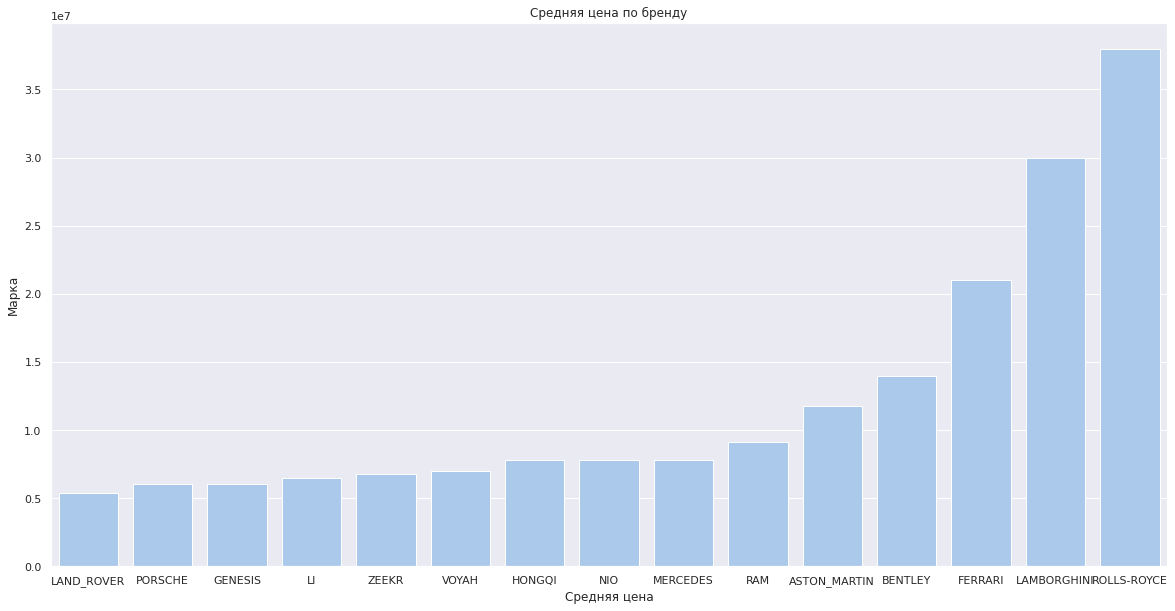

In [147]:
from pyspark.sql.functions import avg, floor, col, desc
from matplotlib.ticker import MultipleLocator

marka_cost_df = df.groupBy("marka").agg(avg("cost").alias("average_cost"), count("*").alias("count")).orderBy(desc("average_cost"))
marka_cost_pandas = spark_to_pandas(marka_cost_df).head(15)

plt.figure(figsize=(20, 10))
sns.barplot(x='marka', y='average_cost', data=marka_cost_pandas[::-1])
plt.title('Средняя цена по бренду')
plt.xlabel('Средняя цена')
plt.ylabel('Марка')

plt.show()

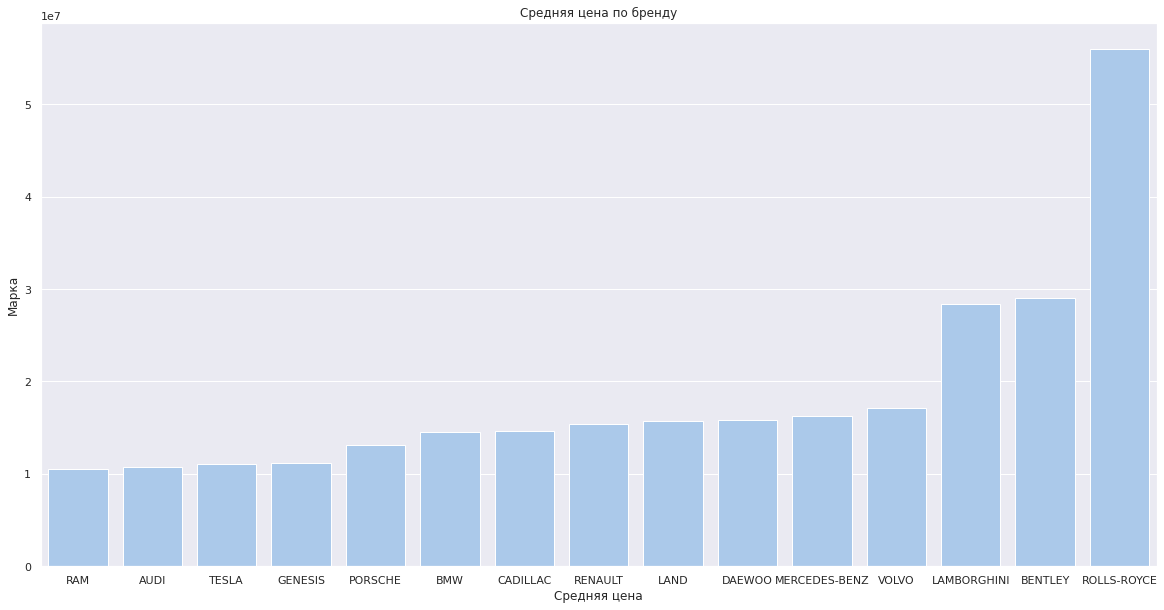

In [150]:
from pyspark.sql.functions import avg, floor, col, desc
from matplotlib.ticker import MultipleLocator

marka_cost_df2 = df.filter(col("year") >= 2023).groupBy("marka").agg(avg("cost").alias("average_cost"), count("*").alias("count")).orderBy(desc("average_cost"))
marka_cost_pandas2 = spark_to_pandas(marka_cost_df2).head(15)

plt.figure(figsize=(20, 10))
sns.barplot(x='marka', y='average_cost', data=marka_cost_pandas2[::-1])
plt.title('Средняя цена по бренду')
plt.xlabel('Средняя цена')
plt.ylabel('Марка')

plt.show()

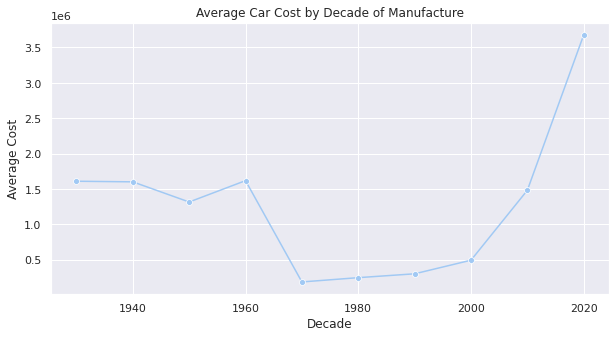

In [168]:
decade_cost_df = df.groupBy("decade").agg(avg("cost").alias("average_cost")).orderBy("decade")
decade_cost_pandas = spark_to_pandas(decade_cost_df)

plt.figure(figsize=(10, 5))
sns.lineplot(x='decade', y='average_cost', data=decade_cost_pandas, marker='o')
plt.title('Средняя цена по десятилетиям производства')
plt.xlabel('Десятилетие')
plt.ylabel('Средняя цена')
plt.show()

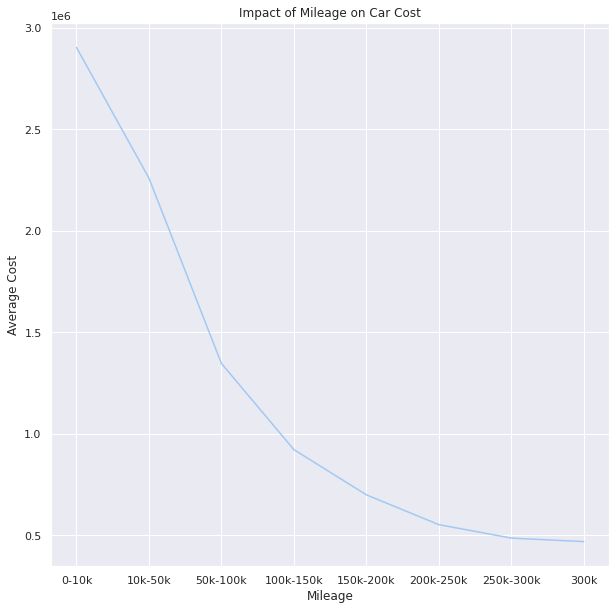

In [128]:
probeg_cost_df = df.groupBy("probeg_interval").agg(avg("cost").alias("average_cost")).orderBy("average_cost")
probeg_cost_pandas = spark_to_pandas(probeg_cost_df)

plt.figure(figsize=(10, 10))
sns.lineplot(data=probeg_cost_pandas[::-1], x='probeg_interval', y='average_cost')
plt.title('Влияние пробега на стоимость автомобиля')
plt.xlabel('Пробег')
plt.ylabel('Средняя цена')
plt.show()

In [124]:
corr_columns = ["cost", "year", "power", "probeg", "marka", "model"]

corr_data = df.select(corr_columns).toPandas()
correlation_matrix = corr_data.corr()

Index(['cost', 'year', 'power', 'probeg'], dtype='object')


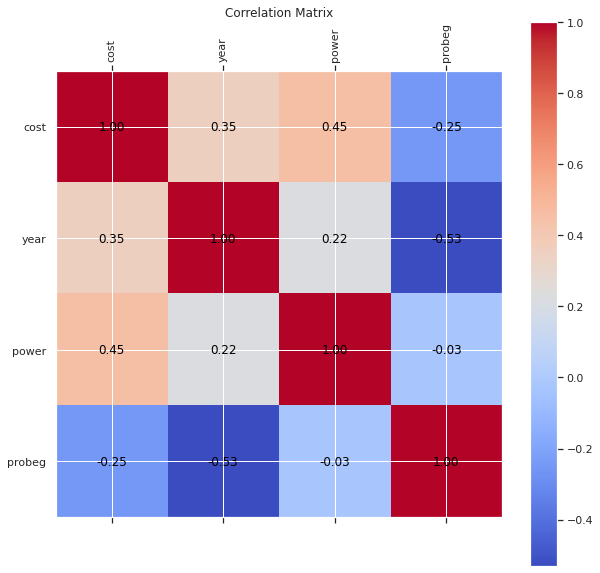

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))

cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

print(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(i, j, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title('Матрица корреляции')
plt.show()

In [187]:
# Group data by country
country_counts = df.groupBy("country").count().collect()

total_count = country_counts['count'].sum()

threshold = total_count * 0.02
large_counts_df = country_counts[country_counts['count'] >= threshold]

country_counts_df = pd.DataFrame(large_counts_df, columns=["country", "count"])

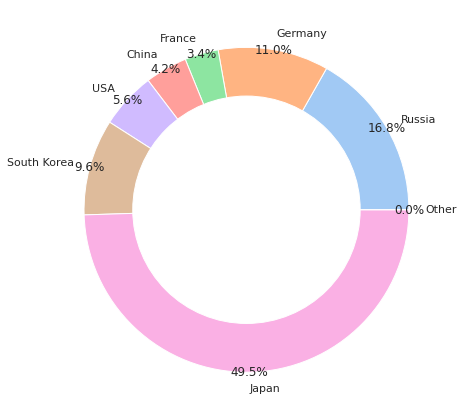

In [188]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(country_counts_df["count"], labels=country_counts_df["country"],autopct='%1.1f%%', pctdistance=1)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.tight_layout()

In [109]:
# Group data by country
country_counts = df.filter((col("date") >= '2023-01-01') & (col("year") >= 2022)).groupBy("country").count().collect()

country_counts_df = pd.DataFrame(country_counts, columns=["country", "count"])

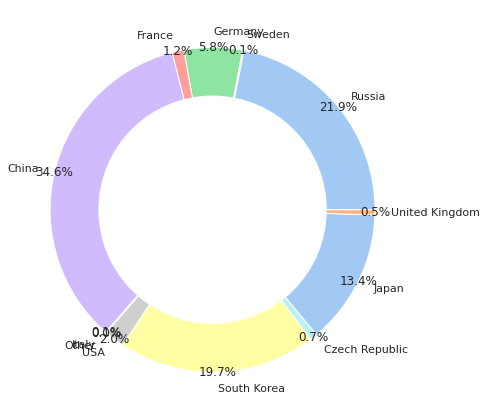

In [110]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(country_counts_df["count"], labels=country_counts_df["country"],autopct='%1.1f%%', pctdistance=1)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.tight_layout()

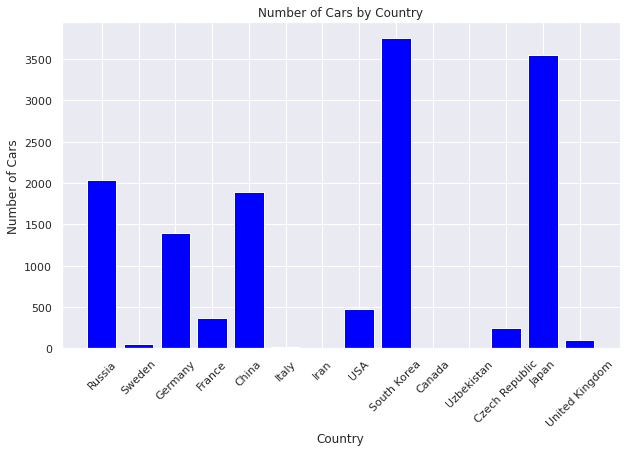

In [126]:
cars_by_country = df.filter((col("date") >= '2022-01-01') & (col("date") <= "2023-01-01") & (col("year") < 2024) & (col("year") > 2020)).groupBy("country").count()
cars_by_country_pd = cars_by_country.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(cars_by_country_pd["country"], cars_by_country_pd["count"], color='blue')
plt.xlabel('Страна')
plt.ylabel('Количество машин')
plt.title('Количество машин по странам производства в период за 2022 год')
plt.xticks(rotation=45)
plt.show()

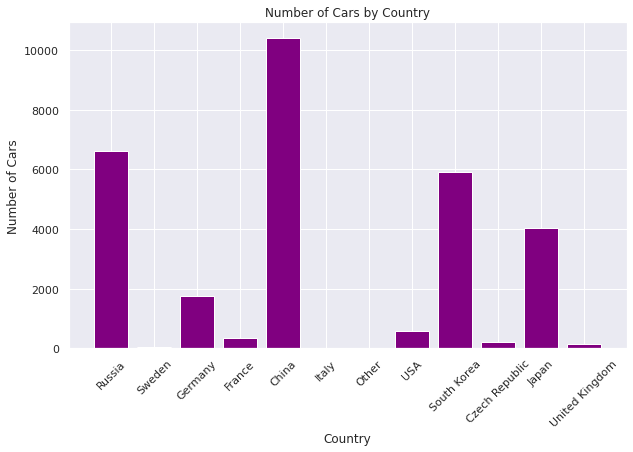

In [127]:
cars_by_country = df.filter((col("date") >= '2023-01-01') & (col("year") >= 2022)).groupBy("country").count()
cars_by_country_pd = cars_by_country.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(cars_by_country_pd["country"], cars_by_country_pd["count"], color='purple')
plt.xlabel('Страна')
plt.ylabel('Количество машин')
plt.title('Количество машин по странам производства после 2022')
plt.xticks(rotation=45)
plt.show()

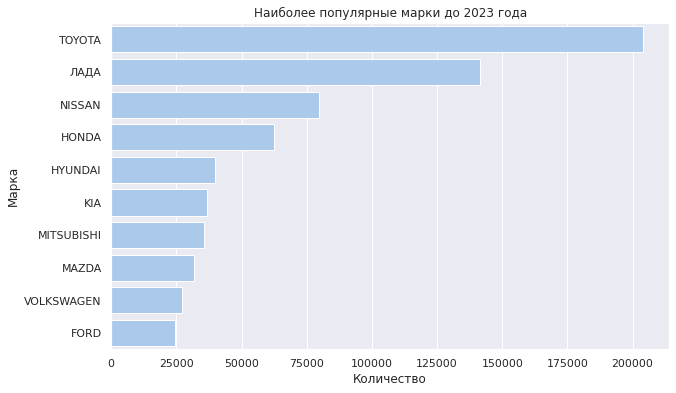

In [8]:
# Определение наиболее популярной марки до 2023 года
df_before_2023 = df.filter(col("year") < 2023)
popular_brands_before_2023 = df_before_2023.groupBy("marka").agg(count("*").alias("count")).orderBy(desc("count"))
popular_brands_before_2023_pd = popular_brands_before_2023.toPandas().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='marka', data=popular_brands_before_2023_pd)
plt.title('Наиболее популярные марки до 2023 года')
plt.xlabel('Количество')
plt.ylabel('Марка')
plt.show()

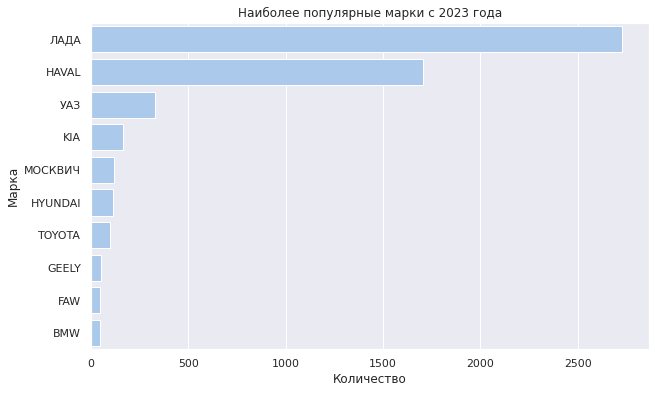

In [10]:
# Определение наиболее популярной марки начиная с 2023 года
df_after_2023 = df.filter(col("year") >= 2023)
popular_brands_after_2023 = df_after_2023.groupBy("marka").agg(count("*").alias("count")).orderBy(desc("count"))
popular_brands_after_2023_pd = popular_brands_after_2023.toPandas().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='marka', data=popular_brands_after_2023_pd)
plt.title('Наиболее популярные марки с 2023 года')
plt.xlabel('Количество')
plt.ylabel('Марка')
plt.show()